In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew,yeojohnson,boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_validate,KFold
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import roc_auc_score,average_precision_score,accuracy_score,confusion_matrix,r2_score,mean_squared_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import xgboost as xgb
import math
import category_encoders as ce
import re
import unidecode
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

# Pierwsza część

In [3]:
df = pd.read_csv('australia.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustSpeed  56420 non-null  float64
 6   WindSpeed9am   56420 non-null  float64
 7   WindSpeed3pm   56420 non-null  float64
 8   Humidity9am    56420 non-null  float64
 9   Humidity3pm    56420 non-null  float64
 10  Pressure9am    56420 non-null  float64
 11  Pressure3pm    56420 non-null  float64
 12  Cloud9am       56420 non-null  float64
 13  Cloud3pm       56420 non-null  float64
 14  Temp9am        56420 non-null  float64
 15  Temp3pm        56420 non-null  float64
 16  RainToday      56420 non-null  int64  
 17  RainTomorrow   56420 non-null  int64  
dtypes: flo

In [4]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333,0.220879,0.220259
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543,0.414843,0.414425
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000,0.000000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000,0.000000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000,0.000000,0.000000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000,1.000000,1.000000


In [5]:
df.isna().sum().sum()

0

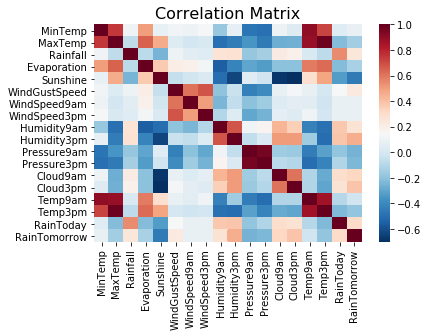

In [6]:
numeric_df = df.select_dtypes(include=np.number)
cor_df = numeric_df.copy()
#-1 means no contact before, calculating correlation with this variable it means NA
corr_numeric = cor_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

Całkiem spora korelacja między niektórymi zmiennymi sugeruje ze moznaby sie bylo pokusic o usuniecie niektorych.

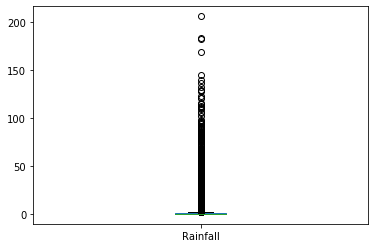

In [7]:
df.Rainfall.plot.box()

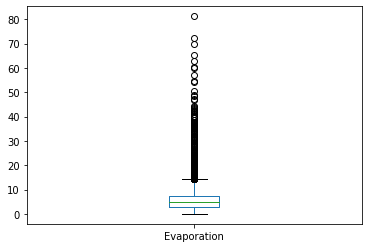

In [8]:
df.Evaporation.plot.box()

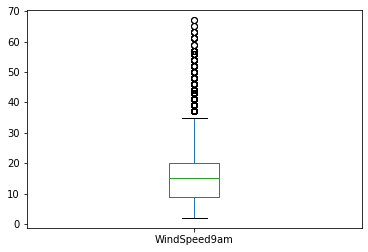

In [9]:
df.WindSpeed9am.plot.box()

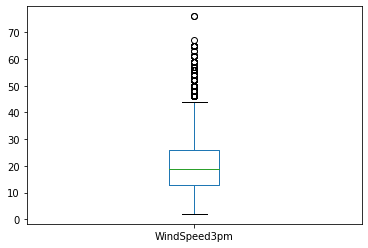

In [10]:
df.WindSpeed3pm.plot.box()

In [11]:
df.skew()

MinTemp          0.052469
MaxTemp          0.185014
Rainfall         7.502521
Evaporation      2.232267
Sunshine        -0.551711
WindGustSpeed    0.960215
WindSpeed9am     0.933070
WindSpeed3pm     0.596814
Humidity9am     -0.489376
Humidity3pm      0.005988
Pressure9am     -0.064353
Pressure3pm     -0.000580
Cloud9am        -0.160677
Cloud3pm        -0.191081
Temp9am          0.111134
Temp3pm          0.195421
RainToday        1.345718
RainTomorrow     1.350070
dtype: float64

Warto przetransformować kolumne Rainfall, aby byla mniej skosna dla lepszego dzialania algorytmow.

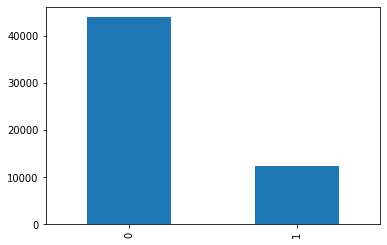

In [12]:
df.RainTomorrow.value_counts().plot(kind='bar')
y = np.array(df['RainTomorrow'])
df.drop('RainTomorrow',axis=1,inplace=True)

Nasz target jest dość niezbalansowany, może to rodzić pewnie problemy.

In [13]:
X_train,X_test,y_train,y_test = train_test_split(df,y,test_size=0.2,random_state = 42)

In [14]:


X_test.Rainfall = X_test.Rainfall.replace(0,1e-6)
X_test.reset_index(inplace=True)
X_test.Rainfall = pd.Series(boxcox(X_test.Rainfall)[0])



X_train.Rainfall = X_train.Rainfall.replace(0,1e-6)
X_train.reset_index(inplace=True)
X_train.Rainfall = pd.Series(boxcox(X_train.Rainfall)[0])



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
def rate_model(model):
    kfold = kfold = KFold(n_splits=10, random_state=42)
    scores = cross_validate(model,X_train,y_train,scoring=['roc_auc','precision','recall','accuracy'],cv=kfold)
    valid = {'precision':[scores['test_precision'].mean()],'recall': [scores['test_recall'].mean()],'accuracy' :[scores['test_accuracy'].mean()],'roc_auc':[scores['test_roc_auc'].mean()]}
    #test
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(pred,y_test)
    cm = confusion_matrix(pred,y_test)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    roc_auc = roc_auc_score(pred,y_test)
    test = {'precision':[precision],'recall': [recall],'accuracy':[model.score(X_test,y_test)],'roc_auc':[roc_auc]}
    x = pd.DataFrame(valid).transpose()
    x1 = pd.DataFrame(test).transpose()
    frames = [x,x1]
    data= pd.concat(frames,axis=1)
    data.columns = ['validate','test']
    return data


In [16]:
logit= LogisticRegression(C=0.01,solver='saga')

In [17]:
log = rate_model(logit)
log

,validate,test
precision,0.727517,0.877248
recall,0.528609,0.947835
accuracy,0.852579,0.855902
roc_auc,0.884385,0.809474


In [18]:
params = {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500,'max_features':'auto','random_state':42}
tree_class = RandomForestClassifier(**params)

In [19]:
tree= rate_model(tree_class)
tree

,validate,test
precision,0.805437,0.843495
recall,0.357640,0.976361
accuracy,0.839529,0.840305
roc_auc,0.862515,0.827116


In [20]:
params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8,'n_estimators':1000,'random_state':42}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)

In [21]:
xgboo = rate_model(xg)
xgboo

,validate,test
precision,0.753852,0.874909
recall,0.528018,0.952267
accuracy,0.858073,0.856611
roc_auc,0.889983,0.814431


Wszystkie 3 modele, których użyłem sprawują się dość dobrze, tzn. uzyskują dobre wyniki na zbiorach testowych. Jednakże patrzać średnio, to minimalnie najlepiej sprawował się Random Forest, jednakże jego przewaga nad pozostałymi jest stosunkowo niewielka.

# Druga część

In [22]:
def rate_model_regr(model,X_train,y_train,X_test,y_test):
    kfold = kfold = KFold(n_splits=10, random_state=42)
    scores = cross_validate(model,X_train,y_train,scoring=['neg_mean_squared_error','r2'],cv=kfold)
    valid = {'RMSE':[np.sqrt(abs(scores['test_neg_mean_squared_error'].mean()))],'R2': [scores['test_r2'].mean()]}
    #test
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test,pred)
    mean = mean_squared_error(y_test,pred,squared=False)
    test = {'RMSE':[mean],'R2': [r2]}
    x = pd.DataFrame(valid).transpose()
    x1 = pd.DataFrame(test).transpose()
    frames = [x,x1]
    data= pd.concat(frames,axis=1)
    data.columns = ['validate','test']
    return data


In [3]:
data = pd.read_csv("/home/arctickey/PycharmProjects/Wum-Zadania/Praca_Domowa_2/allegro-api-transactions.csv")
data.it_location = data.it_location.apply(unidecode.unidecode)
data.it_location = data.it_location.str.lower() #Zamiana na małe litery
def collapse(col):
    col = re.sub(r"\s+", "",col, flags=re.UNICODE)
    return col

data.it_location = data.it_location.apply(collapse) #Kasoawnie wszystkich spacji, daje to spadek unikalnych wartosci o prawie 5 tysiecy

y = data.price
data.date = pd.to_datetime(data.date,format ="%Y-%m-%d %H:%M:%S" )

In [4]:
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['day_of_week'] = data.date.dt.dayofweek
data['hour'] = data.date.dt.hour

Rozbijam daty na kolumny, aby dodać dodatkową inforamcje dla modelu

In [5]:
data.drop(['price','lp','item_id','date'],axis=1,inplace=True)

In [6]:

cols = data.select_dtypes(include='object').columns
for col in cols:
    data[col] = data[col].apply(unidecode.unidecode)
    data[col]= data[col].str.lower() #Zamiana na małe litery
    data[col] = data[col].apply(collapse) #K
cols = list(data.select_dtypes(include='object').columns)

In [7]:
#data.reset_index(inplace=True)
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2,random_state=42)

In [8]:
def skewed_trans(data):
    data.reset_index(inplace=True,drop=True)
    data['it_seller_rating'] = pd.DataFrame(yeojohnson(data['it_seller_rating'])[0])
    data['it_is_brand_zone'] = pd.Series(yeojohnson(data['it_is_brand_zone'])[0])
    data['pay_option_on_delivery'] = pd.Series(yeojohnson(data['pay_option_on_delivery'])[0])
    data['it_quantity'] =pd.Series(yeojohnson(data['it_quantity'])[0])

skewed_trans(X_train)
skewed_trans(X_test)
pd.DataFrame(X_train).isna().sum().sum()


0

In [9]:
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

Kolejny raz transformuje kolumny o sporej skośności, aby poprawić wyniki algorytmów.

In [10]:
#Target encoder
#X_train.reset_index(inplace=True)
#X_test.reset_index(inplace=True)

target_encoder = ce.TargetEncoder(cols=cols,return_df=True,smoothing=2)
target_encoder.fit(X_train,y_train)
X_train = target_encoder.transform(X_train)
X_test = target_encoder.transform(X_test)



In [31]:
ridge = Ridge(random_state=42,alpha=100)
score_cat = rate_model_regr(ridge,X_train,y_train,X_test,y_test)
score_cat

,validate,test
RMSE,275.035162,520.037621
R2,0.369396,0.059836


In [32]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2,random_state=42)

skewed_trans(X_train)
skewed_trans(X_test)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [33]:
james_encoder = ce.JamesSteinEncoder(cols=['categories','seller','it_location','main_category'])
X_train = james_encoder.fit_transform(X_train,y_train)
X_test = james_encoder.transform(X_test)


In [34]:
ridge = Ridge(random_state=42)
score_james = rate_model_regr(ridge,X_train,y_train,X_test,y_test)
score_james

,validate,test
RMSE,129.594061,525.842022
R2,0.796008,0.038731


In [35]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2,random_state=42)

skewed_trans(X_train)
skewed_trans(X_test)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [36]:
ordinal_encoder = ce.OrdinalEncoder(cols=['categories','seller','it_location','main_category'])
X_train = ordinal_encoder.fit_transform(X_train,y_train)
X_test = ordinal_encoder.transform(X_test)

In [37]:
ridge = Ridge(random_state=42)
score_ordinal = rate_model_regr(ridge,X_train,y_train,X_test,y_test)
score_ordinal

,validate,test
RMSE,341.355785,535.238034
R2,0.022472,0.004071


Wyniki nie są zbyt dobre, ale domyślam się ze nie to było celem tego zadania. Jednakże jeśli miałbym wybierać to z trzech użytych przeze mnie encoderów, najlepiej spisał się target encoding, osiągająć najlepsze wyniki zarówno w mierze RMSE jak i R2.